# Shelter Data Analysis

Objectives
1. Investigate crime data to determine if there are any factors which seem to cause or are the result of increased shelter use
2. Develop temporal linear model to predict potential changes to crime metrics
3. Develop a predictive model using Bayesian infernce for crime proximity to shelters



## 0.a Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from geopy.geocoders import Nominatim
from geopy.distance import lonlat, distance
import json
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt
from datetime import datetime
from IPython.display import Image
from sklearn.model_selection import train_test_split

from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot

%matplotlib inline

## 0.1 Shelter Data Preprocessing

In [2]:
df17=pd.read_csv('daily-shelter-occupancy-2017-csv.csv')
df18=pd.read_csv('daily-shelter-occupancy-2018-csv.csv')
df19=pd.read_csv('daily-shelter-occupancy-2019-csv.csv')

In [3]:
df=pd.concat([df17,df18,df19])
df.head()

,_id,OCCUPANCY_DATE,ORGANIZATION_NAME,SHELTER_NAME,SHELTER_ADDRESS,SHELTER_CITY,SHELTER_PROVINCE,SHELTER_POSTAL_CODE,FACILITY_NAME,PROGRAM_NAME,SECTOR,OCCUPANCY,CAPACITY
0,1,2017-01-01T00:00:00,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0
1,2,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0
2,3,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0
3,4,2017-01-01T00:00:00,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0
4,5,2017-01-01T00:00:00,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0


In [4]:
df.isnull().sum()

_id                       0
OCCUPANCY_DATE            0
ORGANIZATION_NAME         0
SHELTER_NAME              0
SHELTER_ADDRESS           0
SHELTER_CITY              0
SHELTER_PROVINCE          0
SHELTER_POSTAL_CODE    5494
FACILITY_NAME             0
PROGRAM_NAME              0
SECTOR                    0
OCCUPANCY                 0
CAPACITY                343
dtype: int64

In [5]:

df['Month_Year']=pd.to_datetime(df['OCCUPANCY_DATE']).dt.to_period('M')
df.head()

,_id,OCCUPANCY_DATE,ORGANIZATION_NAME,SHELTER_NAME,SHELTER_ADDRESS,SHELTER_CITY,SHELTER_PROVINCE,SHELTER_POSTAL_CODE,FACILITY_NAME,PROGRAM_NAME,SECTOR,OCCUPANCY,CAPACITY,Month_Year
0,1,2017-01-01T00:00:00,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,2017-01
1,2,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,2017-01
2,3,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,2017-01
3,4,2017-01-01T00:00:00,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,2017-01
4,5,2017-01-01T00:00:00,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,2017-01


## 0.2 Crime Data Preprocessing

In [6]:
dfCrime=pd.read_csv('MCI_2014_to_2019.csv')
dfCrime.isnull().sum()

X                       0
Y                       0
Index_                  0
event_unique_id         0
occurrencedate          0
reporteddate            0
premisetype             0
ucr_code                0
ucr_ext                 0
offence                 0
reportedyear            0
reportedmonth           0
reportedday             0
reporteddayofyear       0
reporteddayofweek       0
reportedhour            0
occurrenceyear         59
occurrencemonth        59
occurrenceday          59
occurrencedayofyear    59
occurrencedayofweek    59
occurrencehour          0
MCI                     0
Division                0
Hood_ID                 0
Neighbourhood           0
Long                    0
Lat                     0
ObjectId                0
dtype: int64

In [7]:
dfCrime.drop(columns = ['X','Y','Index_','ucr_code','ucr_ext','reportedyear','reportedmonth','reportedday','reporteddayofyear',
                        'reporteddayofweek','occurrenceyear','occurrencemonth','occurrenceday','occurrencedayofyear','occurrencedayofweek',
                        'Division','Hood_ID', 'ObjectId'],inplace =True)

In [8]:
dfCrime.isnull().sum()

event_unique_id    0
occurrencedate     0
reporteddate       0
premisetype        0
offence            0
reportedhour       0
occurrencehour     0
MCI                0
Neighbourhood      0
Long               0
Lat                0
dtype: int64

In [9]:
dfCrime['Reported_Month_Year'] = pd.to_datetime(dfCrime['reporteddate']).dt.to_period('M')
dfCrime['Occurence_Month_Year'] = pd.to_datetime(dfCrime['occurrencedate']).dt.to_period('M')
dfCrime.head()

C:\Users\steve\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,event_unique_id,occurrencedate,reporteddate,premisetype,offence,reportedhour,occurrencehour,MCI,Neighbourhood,Long,Lat,Reported_Month_Year,Occurence_Month_Year
0,GO-20141756319,2014/03/24 00:00:00+00,2014/03/24 00:00:00+00,Commercial,Assault,3,1,Assault,Malvern (132),-79.199081,43.800281,2014-03,2014-03
1,GO-20143006885,2014/09/27 00:00:00+00,2014/09/29 00:00:00+00,Other,B&E,10,16,Break and Enter,Bay Street Corridor (76),-79.386383,43.662472,2014-09,2014-09
2,GO-20141756802,2014/03/24 00:00:00+00,2014/03/24 00:00:00+00,Commercial,B&E,7,6,Break and Enter,West Humber-Clairville (1),-79.612595,43.720406,2014-03,2014-03
3,GO-20141760570,2014/03/24 00:00:00+00,2014/03/24 00:00:00+00,Apartment,B&E,23,15,Break and Enter,Don Valley Village (47),-79.349121,43.782772,2014-03,2014-03
4,GO-20142004859,2014/05/03 00:00:00+00,2014/05/03 00:00:00+00,Commercial,Robbery - Business,2,2,Robbery,Junction Area (90),-79.458778,43.664490,2014-05,2014-05


In [10]:
dfCrime['MCI'].value_counts()

Assault            111423
Break and Enter     43302
Auto Theft          23380
Robbery             21543
Theft Over           6787
Name: MCI, dtype: int64

In [11]:
dfCrime['offence'].value_counts()

Assault                           76124
B&E                               36305
Theft Of Motor Vehicle            23380
Assault With Weapon               18168
Robbery - Mugging                  6847
B&E W'Intent                       5630
Assault Bodily Harm                5104
Theft Over                         3906
Assault Peace Officer              3581
Robbery With Weapon                3578
Robbery - Other                    3533
Robbery - Business                 2434
Assault - Resist/ Prevent Seiz     2376
Robbery - Swarming                 1947
Aggravated Assault                 1864
Theft From Motor Vehicle Over      1590
Discharge Firearm With Intent      1369
Unlawfully In Dwelling-House       1272
Discharge Firearm - Recklessly      896
Robbery - Purse Snatch              835
Robbery - Home Invasion             830
Pointing A Firearm                  737
Theft From Mail / Bag / Key         699
Robbery - Financial Institute       644
Theft Over - Shoplifting            384


## 0.3 Location/Proximity preprocessing

In [12]:
# Obtaining a list of all shelter addresses based on 2017-2019 shelter data
dfAddress = df['SHELTER_ADDRESS'] + ", " + df['SHELTER_CITY']
dfAddress = dfAddress.unique()

#Fixing typos in the addresses
dfAddress[dfAddress == '38 Bathrust St, Toronto'] = '38 Bathurst St, Toronto'
dfAddress[19] = '490 Sherbourne Street, Toronto'

In [13]:
# Using Geolocator from Geopy to obtain geocode addresses the list of shelter addresses 
geolocator = Nominatim(user_agent="Google Maps")
    
shelterLongLat = []
    
for i in range (len(dfAddress)):
    addressLoc = geolocator.geocode(dfAddress[i])
    shelterLoc = lonlat(addressLoc.longitude, addressLoc.latitude)  #Latitude and logitude now be obtained from these addresses
    shelterLongLat.append(shelterLoc)

In [14]:
# Function created to find the distance a crime occured to the nearest shelter, and return both that distance and the address of the shelter
def nearestShelter(crimeLoc): 
    distances = []
    
    for i in range (len(dfAddress)):
        distances.append(distance(shelterLongLat[i], crimeLoc).kilometers)
    minDistIndex = distances.index(min(distances))     
    return min(distances), dfAddress[minDistIndex];

In [15]:
dfCrime['Nearest Shelter Distance']= 4.2  #creating column as float
dfCrime['Nearest Shelter Address']= 'a'   #creating column as string

# Use the lat long of crime indicidents to determine distance to nearest shelter and address, then add to the Crime dataframe

for i in range (len(dfCrime['event_unique_id'])):
    crimeLoc = lonlat(dfCrime['Long'][i],dfCrime['Lat'][i])
    distAddress = nearestShelter(crimeLoc)
    dfCrime['Nearest Shelter Distance'][i] = distAddress[0]
    dfCrime['Nearest Shelter Address'][i] = distAddress[1]

dfCrime.head();

C:\Users\steve\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\steve\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


# 1.1 Crime Data Investigation

### 1.11 Data Resampling

In [16]:
# Convert Shelter data to monthly mean based on occupancy
tableShelter = pd.pivot_table(df, values = 'OCCUPANCY',index=['Month_Year'], aggfunc=np.mean)
tableShelter.head()

,OCCUPANCY
Month_Year,
2017-01,43.381846
2017-02,43.501689
2017-03,43.793761
2017-04,44.576493
2017-05,44.825097


In [17]:
#Frequency table of crimes based on occurance date (only those crimes reported 2014 to 2019)
tableFreqMCI = pd.pivot_table(dfCrime, values = 'event_unique_id',index=['Occurence_Month_Year'], columns=['MCI'], aggfunc='count')
tableFreqMCI = tableFreqMCI.fillna(0)
tableRecentMCI = tableFreqMCI['2017-01'::]

#Combining Shelter data with crime data (MCI only)
tableRecentMCI['Shelter_Occupancy'] = tableShelter
tableRecentMCI.head()

tableRecentMCI.head()

C:\Users\steve\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


MCI,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Shelter_Occupancy
Occurence_Month_Year,,,,,,
2017-01,1450.0,243.0,566.0,323.0,97.0,43.381846
2017-02,1385.0,223.0,490.0,270.0,60.0,43.501689
2017-03,1445.0,285.0,561.0,272.0,79.0,43.793761
2017-04,1686.0,269.0,526.0,325.0,85.0,44.576493
2017-05,1638.0,280.0,502.0,341.0,110.0,44.825097


In [18]:
#Frequency table of crimes by on MCI and premisetype
tableFrequMCIPrem = pd.pivot_table(dfCrime, values = 'event_unique_id',index=['Occurence_Month_Year'], 
                        columns=['MCI','premisetype'], aggfunc='count')
tableFrequMCIPrem = tableFrequMCIPrem.fillna(0)
tableRecentMCIPrem = tableFrequMCIPrem['2017-01'::]

#Combining Shelter data with crime data (MCI and premisetype)
tableRecentMCIPrem['Shelter_Occupancy'] = tableShelter

tableRecentMCIPrem.head()

C:\Users\steve\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


MCI                    Assault                                  Auto Theft  \
premisetype          Apartment Commercial  House  Other Outside  Apartment   
Occurence_Month_Year                                                         
2017-01                  491.0      256.0  200.0  263.0   240.0        2.0   
2017-02                  446.0      258.0  163.0  227.0   291.0        6.0   
2017-03                  524.0      251.0  170.0  221.0   279.0        4.0   
2017-04                  532.0      282.0  184.0  273.0   415.0        1.0   
2017-05                  463.0      254.0  209.0  305.0   407.0        8.0   

MCI                                                  ...    Robbery        \
premisetype          Commercial House Other Outside  ... Commercial House   
Occurence_Month_Year                                 ...                    
2017-01                    35.0  58.0   8.0   140.0  ...       95.0  17.0   
2017-02                    22.0  69.0   2.0   124.0  ...       68.0  11.0   
2017-03                    25.0  92.0   4.0   160.0  ...       98.0   7.0   
2017-04                    30.0  75.0   8.0   155.0  ...       80.0   6.0   
2017-05                    21.0  89.0   9.0   153.0  ...       85.0  11.0   

MCI                                Theft Over                                 \
premisetype          Other Outside  Apartment Commercial House Other Outside   
Occurence_Month_Year                                                           
2017-01               30.0   154.0       21.0       31.0  19.0   6.0    20.0   
2017-02               16.0   144.0       14.0       21.0  11.0   6.0     8.0   
2017-03               22.0   102.0       19.0       32.0   5.0   2.0    21.0   
2017-04               24.0   173.0       14.0       25.0  19.0   6.0    21.0   
2017-05               34.0   181.0       15.0       30.0  21.0  11.0    33.0   

MCI                  Shelter_Occupancy  
premisetype                             
Occurence_Month_Year                    
2017-01                      43.381846  
2017-02                      43.501689  
2017-03                      43.793761  
2017-04                      44.576493  
2017-05                      44.825097  

[5 rows x 26 columns]

### 1.12 Plotting Crime and Shelter Data

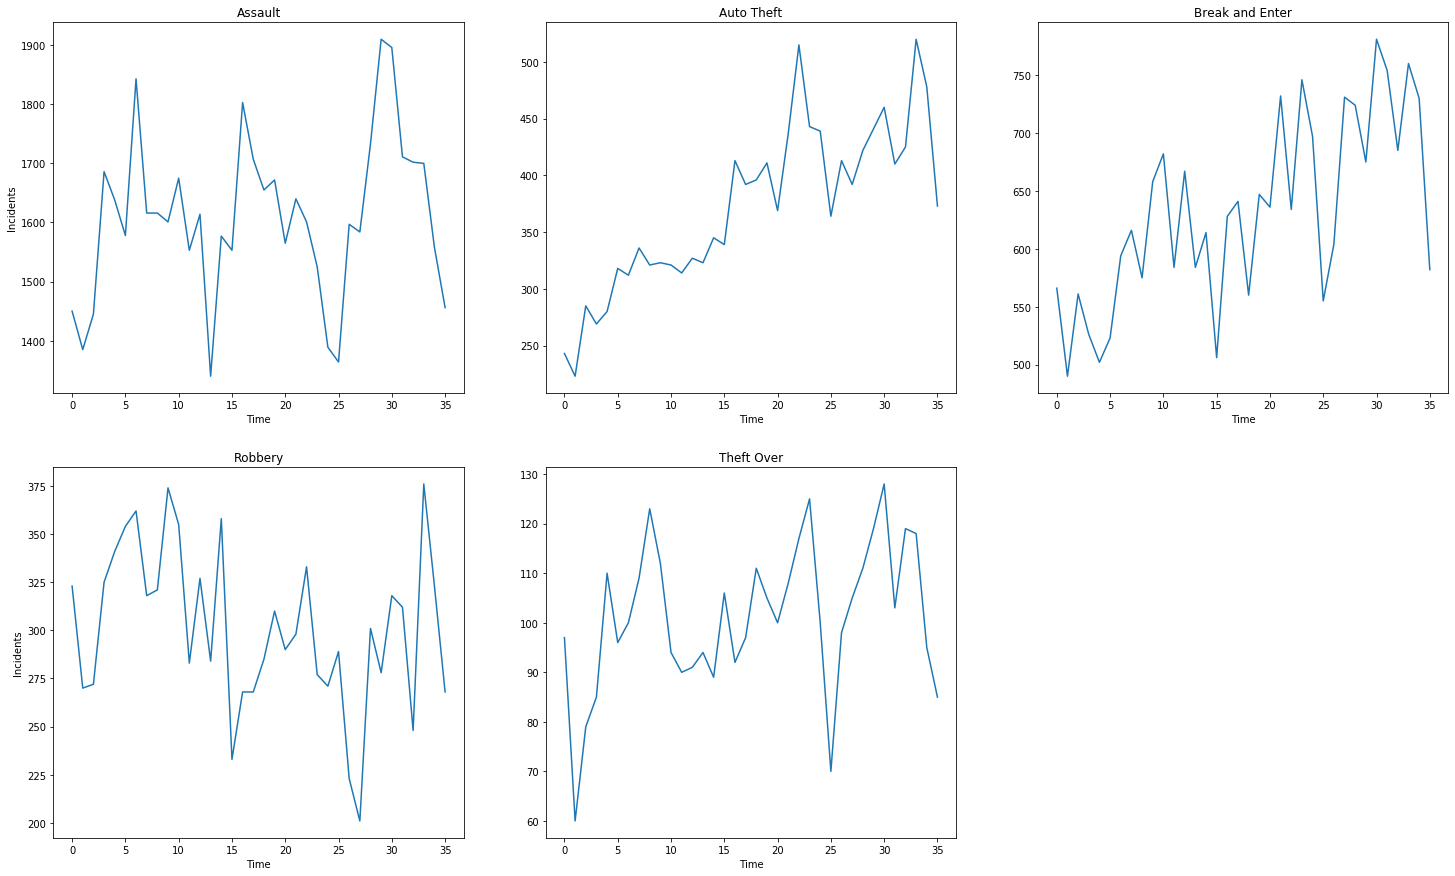

In [19]:
# Plotting MCI based crime indicent stats only

y = tableRecentMCI['Assault']['2017-01'::]
x1= list(range(len(y)))

fig = plt.figure(figsize=(25,15))

ax1 = fig.add_subplot(231)
ax1.set(title='Assault')
ax1.plot(x1, tableRecentMCI['Assault']['2017-01'::])
ax1.set_xlabel('Time')
ax1.set_ylabel('Incidents')

ax1 = fig.add_subplot(232)
ax1.set(title='Auto Theft')
ax1.plot(x1, tableRecentMCI['Auto Theft']['2017-01'::])
ax1.set_xlabel('Time')

ax1 = fig.add_subplot(233)
ax1.set(title='Break and Enter')
ax1.plot(x1, tableRecentMCI['Break and Enter']['2017-01'::])
ax1.set_xlabel('Time')

ax1 = fig.add_subplot(234)
ax1.set(title='Robbery')
ax1.plot(x1, tableRecentMCI['Robbery']['2017-01'::])
ax1.set_xlabel('Time')
ax1.set_ylabel('Incidents')

ax1 = fig.add_subplot(235)
ax1.set(title='Theft Over')
ax1.plot(x1, tableRecentMCI['Theft Over']['2017-01'::])
ax1.set_xlabel('Time')


plt.show()

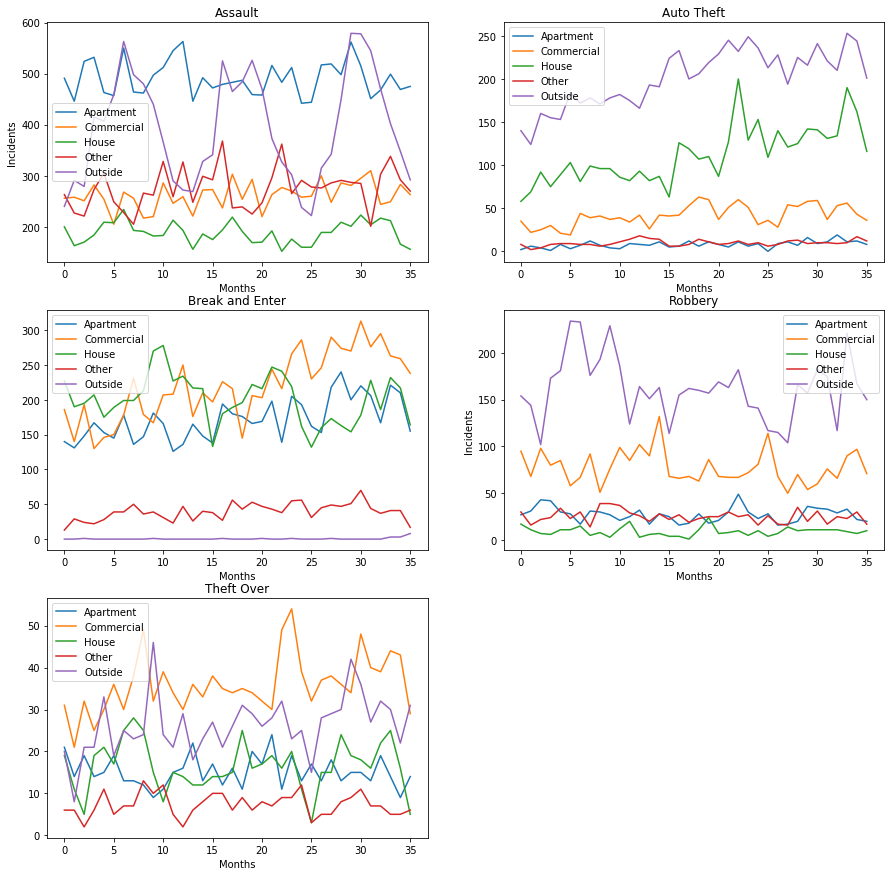

In [20]:
# Plotting MCI and premisetype based crime indicent stats

maxRange = len(tableRecentMCIPrem['Assault'])
x = list(range(maxRange))

fig = plt.figure(figsize=(15,15))


ax1 = fig.add_subplot(321)
ax1.set(title='Assault')
ax1.plot(x, tableRecentMCIPrem['Assault'])
ax1.set_xlabel('Months')
ax1.set_ylabel('Incidents')
plt.legend(labels = ['Apartment', 'Commercial','House' ,'Other' ,'Outside'])

ax1 = fig.add_subplot(322)
ax1.set(title='Auto Theft')
ax1.plot(x, tableRecentMCIPrem['Auto Theft'])
ax1.set_xlabel('Months')
plt.legend(labels = ['Apartment', 'Commercial','House' ,'Other' ,'Outside'])

ax1 = fig.add_subplot(323)
ax1.set(title='Break and Enter')
ax1.plot(x, tableRecentMCIPrem['Break and Enter'])
ax1.set_xlabel('Months')
plt.legend(labels = ['Apartment', 'Commercial','House' ,'Other' ,'Outside'])

ax1 = fig.add_subplot(324)
ax1.set(title='Robbery')
ax1.plot(x, tableRecentMCIPrem['Robbery'])
ax1.set_xlabel('Months')
ax1.set_ylabel('Incidents')
plt.legend(labels = ['Apartment', 'Commercial','House' ,'Other' ,'Outside'])

ax1 = fig.add_subplot(325)
ax1.set(title='Theft Over')
ax1.plot(x, tableRecentMCIPrem['Theft Over'])
ax1.set_xlabel('Months')
plt.legend(labels = ['Apartment', 'Commercial','House' ,'Other' ,'Outside'])

plt.show()

## 2.0 Crime and Shelter Data Modelling

### 2.1 Temporal Data Modelling

#### 2.11 Correlations

In [21]:
# Pearson's R correlation between shelter data and crime MCI's
tableRecentMCI.corr()

MCI,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Shelter_Occupancy
MCI,,,,,,
Assault,1.000000,0.356077,0.398274,0.222966,0.549241,0.196846
Auto Theft,0.356077,1.000000,0.742305,-0.098478,0.559764,0.847883
Break and Enter,0.398274,0.742305,1.000000,0.045119,0.528139,0.618815
Robbery,0.222966,-0.098478,0.045119,1.000000,0.125566,-0.410732
Theft Over,0.549241,0.559764,0.528139,0.125566,1.000000,0.359836
Shelter_Occupancy,0.196846,0.847883,0.618815,-0.410732,0.359836,1.000000


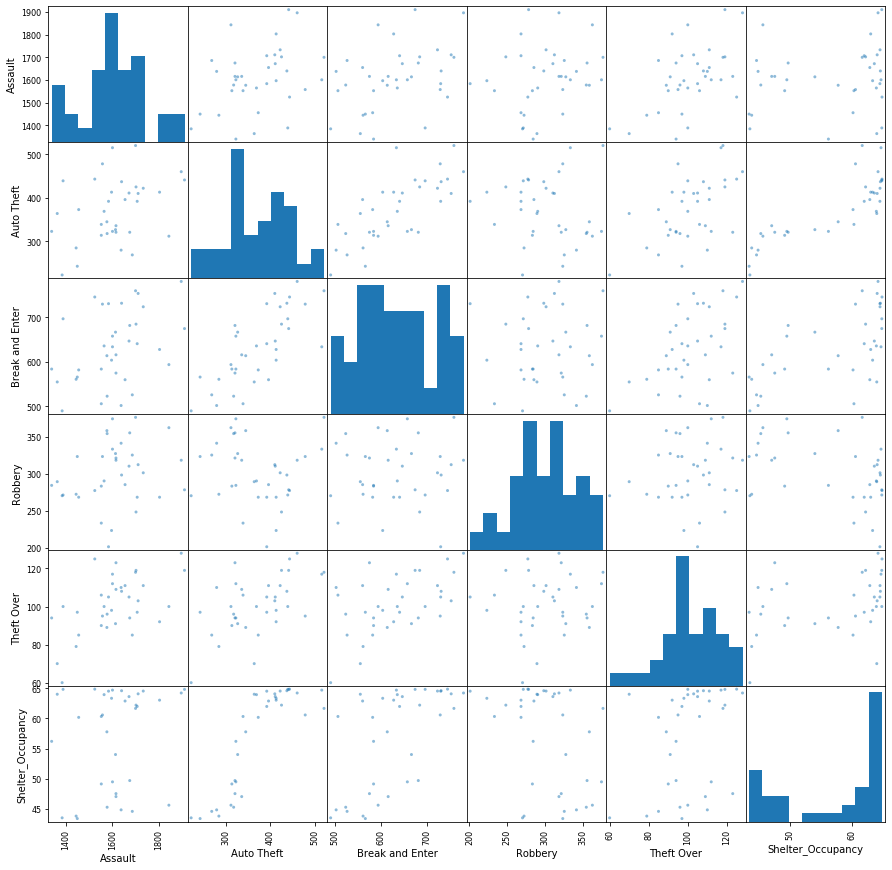

In [22]:
from pandas.plotting import scatter_matrix

# Scatter matrix to visualize correlations

scatter_matrix(tableRecentMCI, figsize =(15,15));

Appears to have linear correlation between Auto Theft and Breaking and Entering. Auto Theft and Breaking and entering also seem to be correlated to each other as well.

C:\Users\steve\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


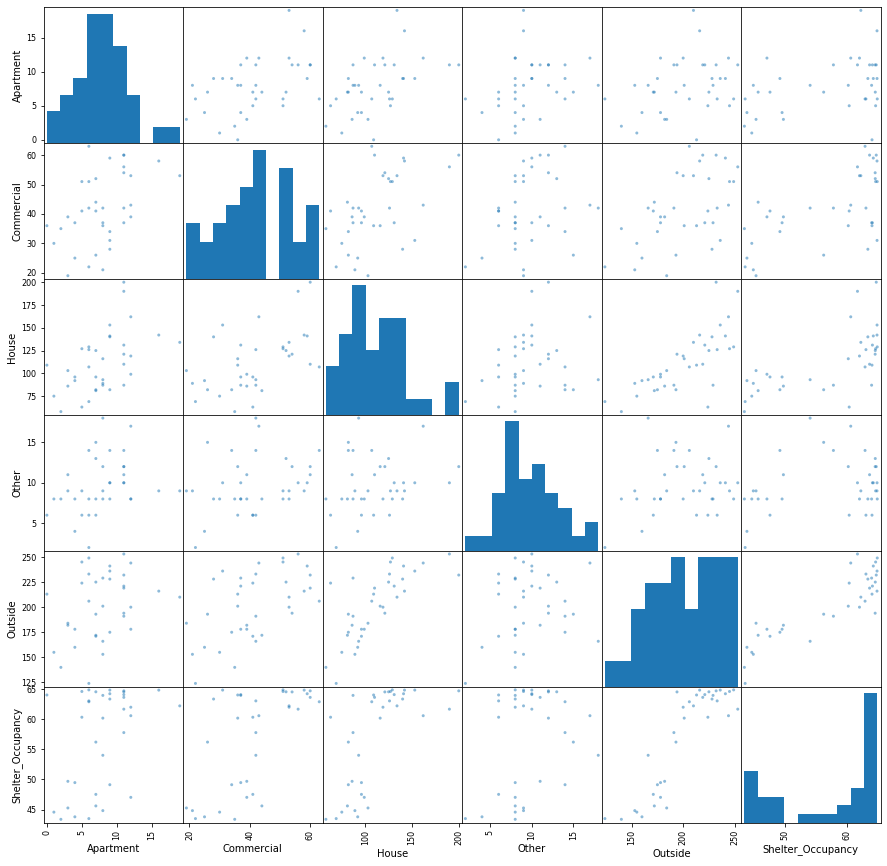

In [23]:
from pandas.plotting import scatter_matrix

# Scatter matrix to visualize correlations

tableRecentMCIPremAuto = tableRecentMCIPrem['Auto Theft']
tableRecentMCIPremAuto["Shelter_Occupancy"] = tableShelter

scatter_matrix(tableRecentMCIPremAuto, figsize =(15,15));

In [24]:
tableRecentMCIPremAuto.corr()

premisetype,Apartment,Commercial,House,Other,Outside,Shelter_Occupancy
premisetype,,,,,,
Apartment,1.000000,0.466942,0.511934,0.299963,0.330264,0.426481
Commercial,0.466942,1.000000,0.518299,0.287601,0.554469,0.638178
House,0.511934,0.518299,1.000000,0.231250,0.743482,0.659664
Other,0.299963,0.287601,0.231250,1.000000,0.212573,0.275162
Outside,0.330264,0.554469,0.743482,0.212573,1.000000,0.882352
Shelter_Occupancy,0.426481,0.638178,0.659664,0.275162,0.882352,1.000000


Including only outdoor auto thefts seems to improve the correlation, and makes more sense from a mechanistic perspective.

In [25]:
# Examining the pearson's R correlation with specific offences as well to determine if ther are any interesting patterns
tableOffence = pd.pivot_table(dfCrime, values = 'event_unique_id',index=['Occurence_Month_Year'], 
                              columns=['offence'], aggfunc='count')
tableRecentOffence = tableOffence['2017-01'::]
tableRecentOffence['Shelter'] = tableShelter
tableRecentOffence.fillna(0)

corel = tableRecentOffence.corr()
corel['Shelter']

C:\Users\steve\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


offence
Administering Noxious Thing       0.189011
Aggravated Aslt Peace Officer     0.015675
Aggravated Assault                0.092459
Aggravated Assault Avails Pros         NaN
Air Gun Or Pistol: Bodily Harm   -0.515850
Assault                           0.207896
Assault - Force/Thrt/Impede       0.284868
Assault - Resist/ Prevent Seiz    0.012803
Assault Bodily Harm              -0.216409
Assault Peace Officer             0.194522
Assault Peace Officer Wpn/Cbh     0.106419
Assault With Weapon               0.173492
B&E                               0.598004
B&E - M/Veh To Steal Firearm      0.149787
B&E - To Steal Firearm                 NaN
B&E Out                           0.023198
B&E W'Intent                      0.513752
Crim Negligence Bodily Harm      -0.129816
Disarming Peace/Public Officer   -0.110711
Discharge Firearm - Recklessly    0.323943
Discharge Firearm With Intent     0.125873
Pointing A Firearm                0.067056
Robbery - Armoured Car            0.134254
Rob

Strongest correlation with Theft of Motor Vehicle

### 2.11 Linear Modeling of Outdoor Auto Theft vs Shelter Occupancy

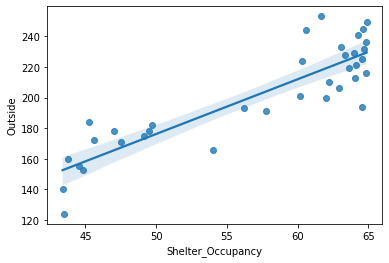

In [26]:
import scipy.stats as stats
import statsmodels.formula.api as smf

#tableRecentMCI = tableRecentMCI.rename(columns = {'Auto Theft':'Auto_Theft'})

sns.regplot(y="Outside", x="Shelter_Occupancy", data=tableRecentMCIPremAuto, fit_reg = True)

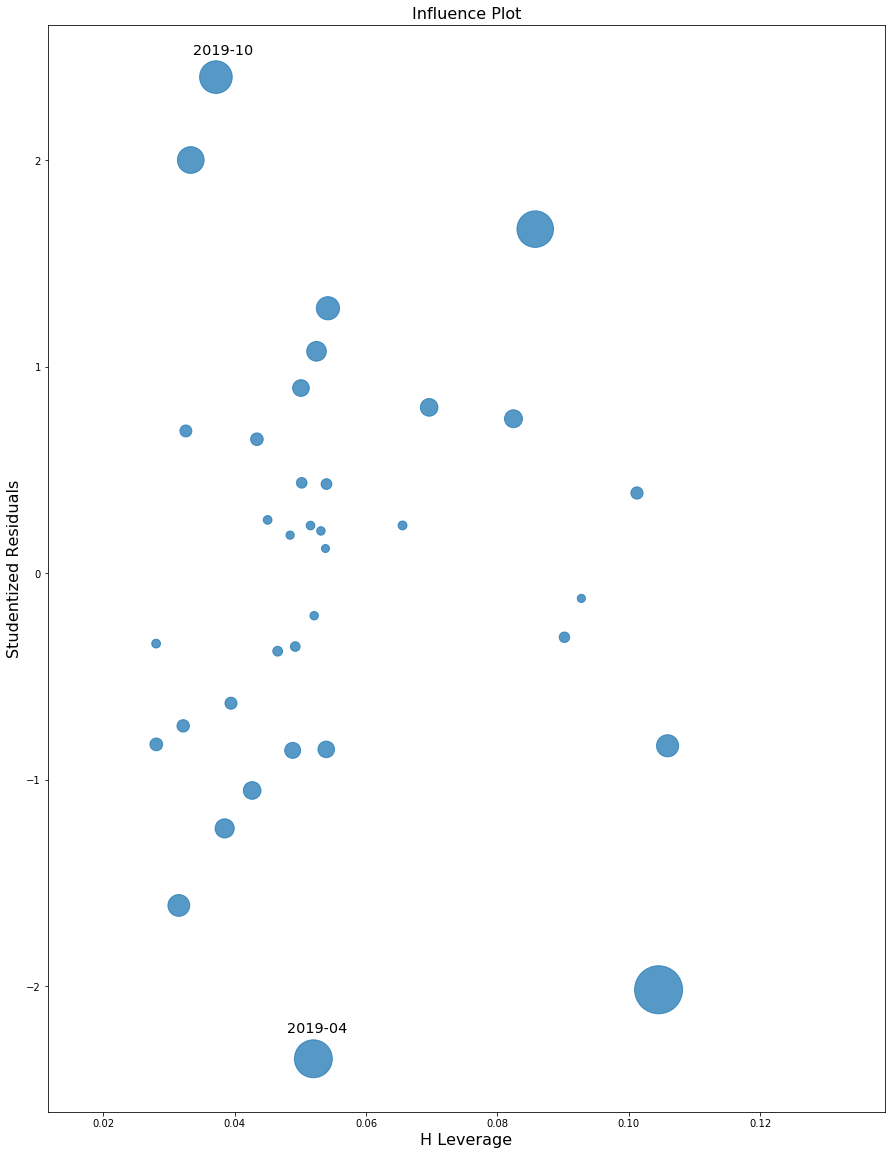

In [27]:
m1 = smf.ols(formula='Outside ~ Shelter_Occupancy', data=tableRecentMCIPremAuto).fit()
fig, ax = plt.subplots(figsize=(15,20))
fig = sm.graphics.influence_plot(m1, ax=ax, criterion="cooks")

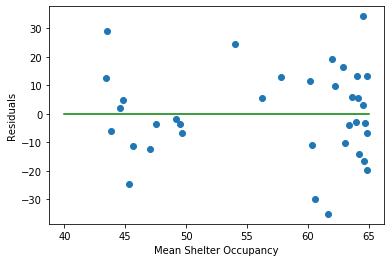

In [28]:
plt.scatter(tableRecentMCI["Shelter_Occupancy"], m1.fittedvalues - tableRecentMCIPremAuto["Outside"])
plt.xlabel("Mean Shelter Occupancy")
plt.ylabel("Residuals")
plt.plot([40, 65], [0, 0], 'g-')
#plt.savefig('second_residuals.png')

While leverage is higher for 2018-11 and 2019-10, they are still approximately 3 SD from the mean and can be retained

In [29]:
print (m1.summary())

                            OLS Regression Results                            
Dep. Variable:                Outside   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     119.5
Date:                Sat, 08 Aug 2020   Prob (F-statistic):           1.13e-12
Time:                        01:00:04   Log-Likelihood:                -149.60
No. Observations:                  36   AIC:                             303.2
Df Residuals:                      34   BIC:                             306.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.3427     18.79

## 2.0 Investigation of Address and Proximity Information

In [30]:
# List of those shelters with high crime rates near their location (within 1km). 
#Limited by recent dates i.e. 2017 to end of 2019.

tableCrimeRecent = dfCrime[dfCrime["Occurence_Month_Year"]>="2017-01"]
tableTemp = tableCrimeRecent[tableCrimeRecent['Nearest Shelter Distance'] <= 1]
tableTemp = tableTemp[tableTemp['premisetype']== 'Outside']

tableMCIShelters= pd.pivot_table(tableTemp, values = 'event_unique_id',index=['Nearest Shelter Address'], columns=['MCI'], 
                      aggfunc='count')
tableMCIShelters.sort_values(by = ('Assault'), ascending = False)

MCI,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
Nearest Shelter Address,,,,,
"20 Gerrard Street East, Toronto",605.0,38.0,NaN,209.0,14.0
"805A Wellington Street W, Toronto",333.0,50.0,NaN,44.0,15.0
"67 Adelaide Street East, Toronto",332.0,34.0,2.0,78.0,19.0
"248 Dufferin Street, Toronto",266.0,74.0,1.0,54.0,13.0
"512 Jarvis St., Toronto",236.0,44.0,NaN,51.0,13.0
...,...,...,...,...,...
"339 George Street, Toronto",23.0,6.0,NaN,6.0,NaN
"360 Lesmill Road, North York",20.0,19.0,NaN,2.0,2.0
"191 Spadina Road, Toronto",16.0,10.0,NaN,5.0,2.0


In [31]:
tableMCIShelters.sort_values(by = ('Auto Theft'), ascending = False)

MCI,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
Nearest Shelter Address,,,,,
"25 Canterbury Place, North York",156.0,123.0,NaN,133.0,26.0
"248 Dufferin Street, Toronto",266.0,74.0,1.0,54.0,13.0
"616 Vaughan Road Toronto, Toronto",142.0,66.0,NaN,56.0,4.0
"2714 Danforth Avenue, Toronto",192.0,62.0,NaN,58.0,8.0
"265 Queens Drive, Toronto",100.0,61.0,NaN,40.0,NaN
...,...,...,...,...,...
"191 Spadina Road, Toronto",16.0,10.0,NaN,5.0,2.0
"107 Jarvis Street, Toronto",102.0,9.0,NaN,38.0,3.0
"3410 Bayview Avenue, Toronto",6.0,6.0,1.0,5.0,2.0


## 2.1 Proximity Data Visualization

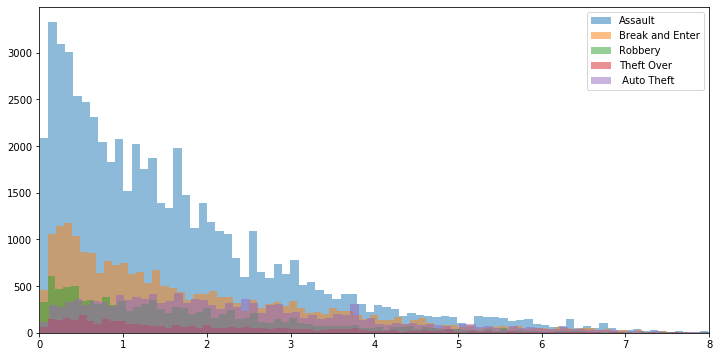

In [32]:
#Overlapping distance data for each MCI based on distance to nearest shelter

bins, alpha = 100, 0.5

fig = plt.figure(figsize=(12,6))

dfAssaultDist = tableCrimeRecent[tableCrimeRecent['MCI']  == 'Assault']['Nearest Shelter Distance']
dfBreakEnterDist = tableCrimeRecent[tableCrimeRecent['MCI']  == 'Break and Enter']['Nearest Shelter Distance']
dfRobberyDist = tableCrimeRecent[tableCrimeRecent['MCI']  == 'Robbery']['Nearest Shelter Distance']
dfTheftOverDist = tableCrimeRecent[tableCrimeRecent['MCI']  == 'Theft Over']['Nearest Shelter Distance']
dfAutoTheftDist = tableCrimeRecent[tableCrimeRecent['MCI']  == 'Auto Theft']['Nearest Shelter Distance']

plt.hist(dfAssaultDist,  bins= bins, alpha = alpha, label = 'Assault')
plt.hist(dfBreakEnterDist,  bins= bins, alpha = alpha, label = 'Break and Enter')
plt.hist(dfRobberyDist,  bins= bins, alpha = alpha, label = 'Robbery')
plt.hist(dfTheftOverDist,  bins= bins, alpha = alpha, label = "Theft Over")
plt.hist(dfAutoTheftDist,  bins= bins, alpha = alpha, label = ' Auto Theft')
#plt.set(title ='Crime vs Location')
plt.xlim(0, 8)
plt.legend(loc = 'best')

plt.show()

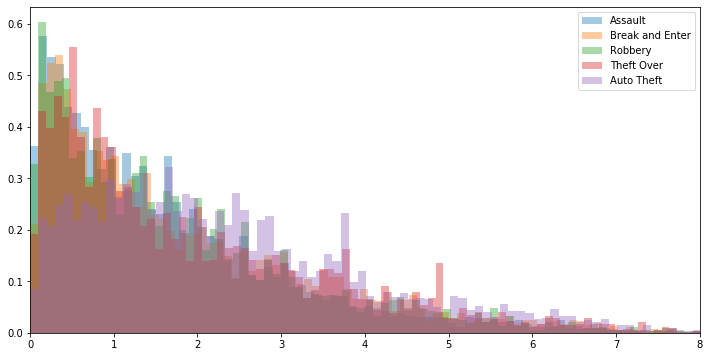

In [33]:
#Normalized cverlapping distance data for each MCI based on distance to nearest shelter

bins, alpha = 100, 0.4

fig = plt.figure(figsize=(12,6))

plt.hist(dfAssaultDist,  bins= bins, alpha = alpha, label = 'Assault', density =True)
plt.hist(dfBreakEnterDist,  bins= bins, alpha = alpha, label = 'Break and Enter', density =True)
plt.hist(dfRobberyDist,  bins= bins, alpha = alpha, label = 'Robbery', density =True)
plt.hist(dfTheftOverDist,  bins= bins, alpha = alpha, label = "Theft Over", density =True)
plt.hist(dfAutoTheftDist,  bins= bins, alpha = alpha, label = 'Auto Theft', density =True)
plt.legend(loc = 'best')
plt.xlim(0, 8)

plt.show()

## 2.2  Baysian Inference Modelling

### 2.2.1 Markov Chain Monte Carlo for Baysian Modelling of Outdside Assualts base on proximity to Shelters

In [34]:
assaults = tableCrimeRecent[tableCrimeRecent['MCI'] == 'Assault']
assaultsOutside = assaults[assaults['premisetype']== 'Outside']['Nearest Shelter Distance']
assaultsOutside.reset_index(drop=True);

In [35]:
with pm.Model() as model_expA:
    
    #Prior
    
    lamda = pm.Uniform("lamda", lower=0, upper=20, testval=1)
       
    #Likelihood
    likelihood = pm.Exponential("likelihood", lam = lamda, observed = assaultsOutside.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(10000, chains=4, step=step, start=start, progressbar=True)
    burned_traceA = trace[3000::2]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lamda]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 104 seconds.
The number of effective samples is smaller than 10% for some parameters.


C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC4326AB48>,
      dtype=object)

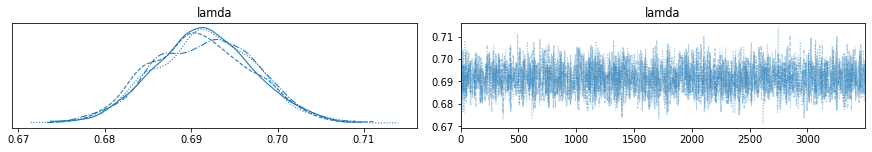

In [36]:
pm.traceplot(burned_traceA)

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC4331FA88>],
      dtype=object)

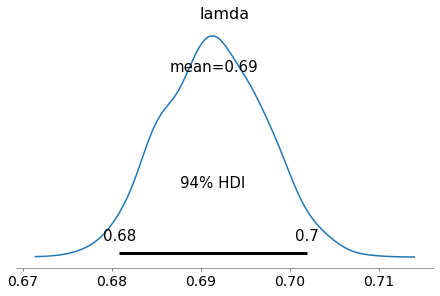

In [37]:
pm.plot_posterior(burned_traceA)

In [38]:
ppcA = pm.sample_posterior_predictive(burned_traceA, samples=1000, model=model_expA)

C:\Users\steve\anaconda3\lib\site-packages\pymc3\sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


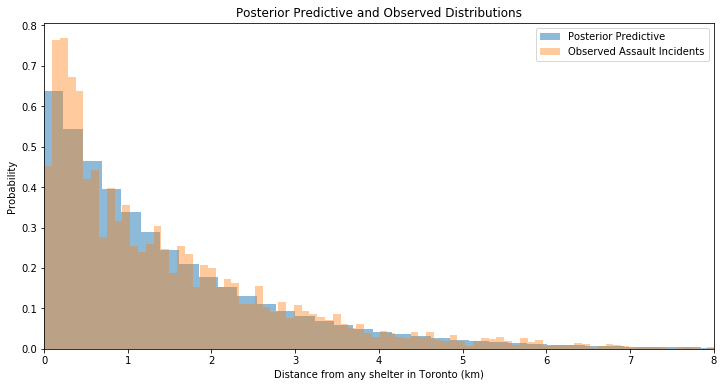

In [39]:
_, ax = plt.subplots(figsize = (12,6))
ax.hist(ppcA['likelihood'].flatten(), bins = bins, alpha=0.5,density = True, label = 'Posterior Predictive')
plt.xlim(0, 8)
ax.set(title='Posterior Predictive and Observed Distributions', xlabel='Distance from any shelter in Toronto (km)', ylabel='Probability')
plt.hist(assaultsOutside,  bins= bins, alpha = alpha, label = 'Observed Assault Incidents', density =True)
plt.legend(loc ='best');

In [40]:
pm.summary(burned_traceA)

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lamda,0.691,0.006,0.681,0.702,0.0,0.0,2112.0,2110.0,2124.0,2870.0,1.0


### 2.2.1 Markov Chain Monte Carlo for Baysian Modelling of Outside Auto Thefts based on proximity to Shelters

In [41]:
autoTheft = tableCrimeRecent[tableCrimeRecent['MCI'] == 'Auto Theft']
autoTheftOutside = autoTheft[autoTheft['premisetype']== 'Outside']['Nearest Shelter Distance']
autoTheftOutside.reset_index(drop=True);

In [42]:
with pm.Model() as model_expAT:
    
    #Prior
    
    lamda = pm.Uniform("lamda", lower=0, upper=20, testval=1)
       
    #Likelihood
    likelihood = pm.Exponential("likelihood", lam = lamda, observed = autoTheftOutside.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(10000, chains=4, step=step, start=start, progressbar=True)
    burned_traceAT = trace[3000::2]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lamda]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 109 seconds.
The number of effective samples is smaller than 10% for some parameters.


C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC4A670048>,
      dtype=object)

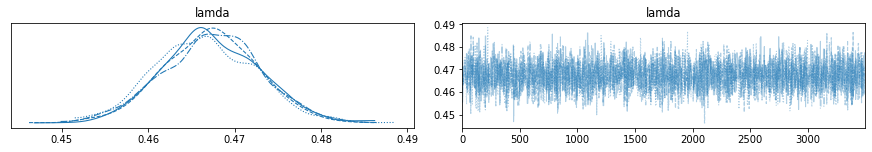

In [43]:
pm.traceplot(burned_traceAT)

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC4A85B248>],
      dtype=object)

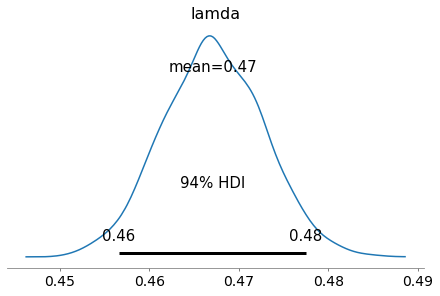

In [44]:
pm.plot_posterior(burned_traceAT)

In [45]:
ppcAT = pm.sample_posterior_predictive(burned_traceAT, samples=1000, model=model_expAT)

C:\Users\steve\anaconda3\lib\site-packages\pymc3\sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


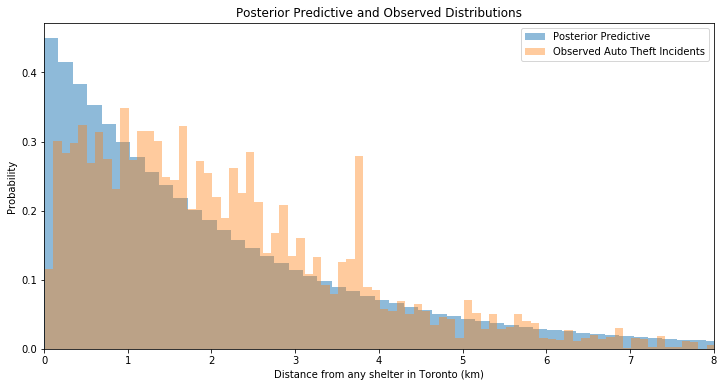

In [46]:
_, ax = plt.subplots(figsize = (12,6))
ax.hist(ppcAT['likelihood'].flatten(), bins = 200, alpha=0.5,density = True, label = 'Posterior Predictive')
plt.xlim(0, 8)
ax.set(title='Posterior Predictive and Observed Distributions', xlabel='Distance from any shelter in Toronto (km)',
       ylabel='Probability')
plt.hist(autoTheftOutside,  bins= bins, alpha = alpha, label = 'Observed Auto Theft Incidents', density =True)
plt.legend(loc ='best');

In [59]:
pm.summary(burned_traceAT)

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lamda,0.467,0.006,0.457,0.478,0.0,0.0,2504.0,2504.0,2517.0,3176.0,1.01


### 2.2.3 Markov Chain Monte Carlo for Baysian Modelling of Outdside Robberies based on proximity to Shelters

In [47]:
robbery = tableCrimeRecent[tableCrimeRecent['MCI'] == 'Robbery']
robberyOutside = robbery[robbery['premisetype']== 'Outside']['Nearest Shelter Distance']
robberyOutside.reset_index(drop=True);

In [48]:
with pm.Model() as model_expRob:
    
    #Prior
    
    lamda = pm.Uniform("lamda", lower=0, upper=20, testval=1)
       
    #Likelihood
    likelihood = pm.Exponential("likelihood", lam = lamda, observed = robberyOutside.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(10000, chains=4, step=step, start=start, progressbar=True)
    burned_traceRob = trace[3000::2]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lamda]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 102 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC4E26EB08>,
      dtype=object)

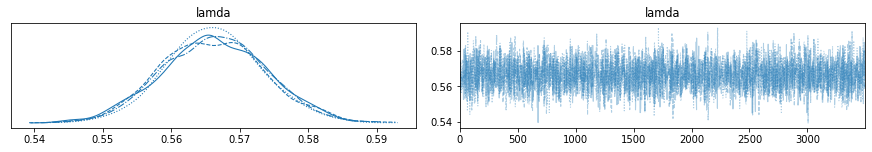

In [49]:
pm.traceplot(burned_traceRob)

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EBB6F45708>],
      dtype=object)

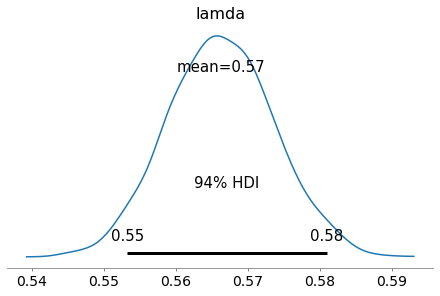

In [50]:
pm.plot_posterior(burned_traceRob)

In [51]:
ppcRob = pm.sample_posterior_predictive(burned_traceRob, samples=1000, model=model_expRob)

C:\Users\steve\anaconda3\lib\site-packages\pymc3\sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


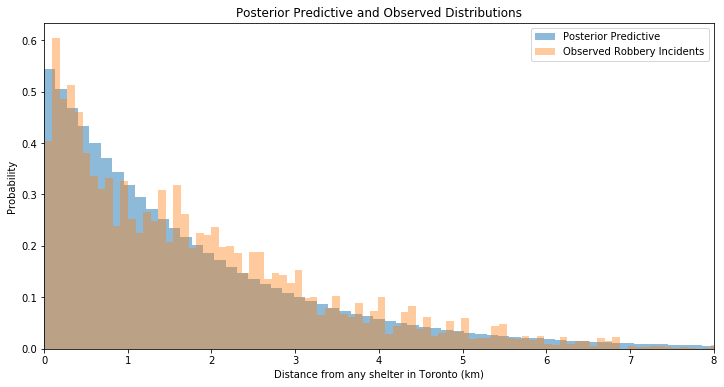

In [52]:
_, ax = plt.subplots(figsize = (12,6))
ax.hist(ppcRob['likelihood'].flatten(), bins = 200, alpha=0.5,density = True, label = 'Posterior Predictive')
plt.xlim(0, 8)
ax.set(title='Posterior Predictive and Observed Distributions', xlabel='Distance from any shelter in Toronto (km)', 
       ylabel='Probability')
plt.hist(robberyOutside,  bins= bins, alpha = alpha, density =True, label ='Observed Robbery Incidents')
plt.legend(loc ='best');

In [60]:
pm.summary(burned_traceRob)

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lamda,0.566,0.007,0.553,0.581,0.0,0.0,3177.0,3173.0,3181.0,2745.0,1.0


### 2.2.3 Markov Chain Monte Carlo for Baysian Modelling of Break and Entering based on proximity to Shelters

In [53]:
breakEnter = tableCrimeRecent[tableCrimeRecent['MCI'] == 'Break and Enter']['Nearest Shelter Distance']
breakEnter.reset_index(drop=True);

In [54]:
with pm.Model() as model_expBE:
    
    #Prior
    
    lamda = pm.Uniform("lamda", lower=0, upper=20, testval=1)
       
    #Likelihood
    likelihood = pm.Exponential("likelihood", lam = lamda, observed = breakEnter.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(10000, chains=4, step=step, start=start, progressbar=True)
    burned_traceBE = trace[3000::2]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lamda]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 110 seconds.
The number of effective samples is smaller than 10% for some parameters.


C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC4E612A88>,
      dtype=object)

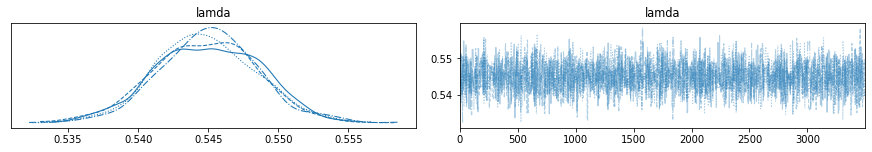

In [55]:
pm.traceplot(burned_traceBE)

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC4E27E3C8>],
      dtype=object)

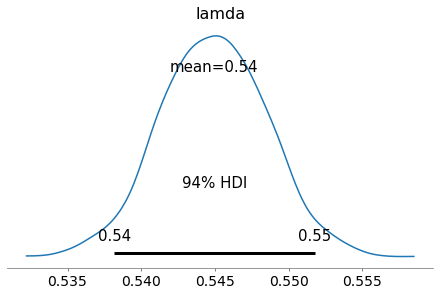

In [56]:
pm.plot_posterior(burned_traceBE)

In [57]:
ppcBE = pm.sample_posterior_predictive(burned_traceBE, samples=1000, model=model_expBE)

C:\Users\steve\anaconda3\lib\site-packages\pymc3\sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


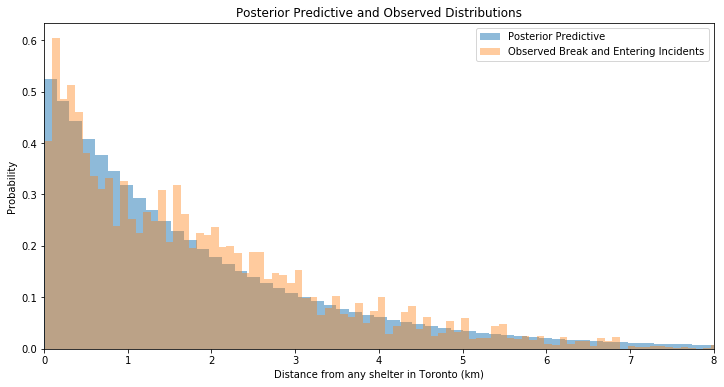

In [58]:
_, ax = plt.subplots(figsize = (12,6))
ax.hist(ppcBE['likelihood'].flatten(), bins = 200, alpha=0.5,density = True,label = 'Posterior Predictive')
plt.xlim(0, 8)
ax.set(title='Posterior Predictive and Observed Distributions', xlabel='Distance from any shelter in Toronto (km)', 
       ylabel='Probability')
plt.hist(robberyOutside,  bins= bins, alpha = alpha, label = 'Observed Break and Entering Incidents', density =True)
plt.legend(loc ='best');

In [61]:
pm.summary(burned_traceBE)

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lamda,0.545,0.004,0.538,0.552,0.0,0.0,2472.0,2472.0,2471.0,2720.0,1.0


### 2.2.3 Markov Chain Monte Carlo for Baysian Modelling of Break and Entering based on proximity to Shelters

In [65]:
theftOver = tableCrimeRecent[tableCrimeRecent['MCI'] == 'Theft Over']
theftOverOutside = theftOver[theftOver['premisetype']== 'Outside']['Nearest Shelter Distance']
theftOverOutside.reset_index(drop=True);

In [66]:
with pm.Model() as model_expTO:
    
    #Prior
    
    lamda = pm.Uniform("lamda", lower=0, upper=20, testval=1)
       
    #Likelihood
    likelihood = pm.Exponential("likelihood", lam = lamda, observed = theftOverOutside.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(10000, chains=4, step=step, start=start, progressbar=True)
    burned_traceTO = trace[3000::2]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lamda]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 95 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC50BB98C8>,
      dtype=object)

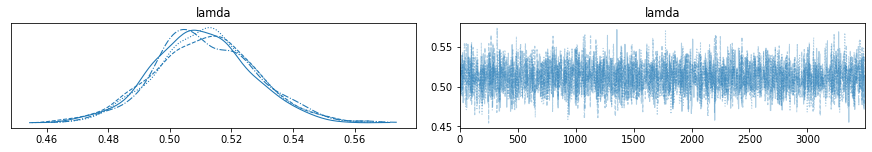

In [67]:
pm.traceplot(burned_traceTO)

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC50867648>],
      dtype=object)

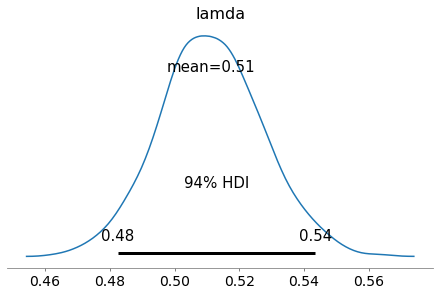

In [68]:
pm.plot_posterior(burned_traceTO)

In [69]:
ppcTO = pm.sample_posterior_predictive(burned_traceTO, samples=1000, model=model_expTO)

C:\Users\steve\anaconda3\lib\site-packages\pymc3\sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [70]:
pm.summary(burned_traceTO)

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lamda,0.511,0.016,0.482,0.543,0.0,0.0,3149.0,3149.0,3135.0,3058.0,1.0


In [74]:
pm.summary(burned_traceTO).r_hat

C:\Users\steve\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


lamda    1.0
Name: r_hat, dtype: float64